Created on Sat Nov 06 16:00:00 2021. @author: Cedric Yu


# Climate Change: Global Temperature

We study the global temperatures dataset available on:

https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

We focus on the time series 'LandAverageTemperature', which is the monthly global average land temperature in Celsius.

We first explore the given relative absolute uncertainty of the time series, and find that it is large during the early record 1750-1849. Because of this, we decide to take the yearly averages and only use the data from 1850-2015.

By eyeballing and using the augmented Dickey-Fuller test, we see a clear increasing trend (hence global 'warming'), which is rendered stationary by taking the first difference.

Next, we study the auto-correlation function (ACF) and partial auto-correlation function (PACF), we find that the first difference can be described by an AR(3) model. We fit AR(3) models on the series, using fixed partitioning and rolling forecast, and compare the model performance.

## Preamble

In [1]:
import pandas as pd
# Make the output look better
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None  # default='warn' # ignores warning about dropping columns inplace


import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

import os
os.chdir(r'C:\Users\Cedric Yu\Desktop\Works\13_time_series_global_temperatures')


## load dataset and parse datetime

In [2]:
"""# import GlobalTemperatures dataset and parse datetime column 'dt'"""

from datetime import datetime
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

global_temperatures = pd.read_csv('GlobalTemperatures.csv', header = [0], parse_dates= [0], date_parser=parser)

## Preliminary observations

In [4]:
global_temperatures.tail()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
3187,2015-08-01,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057
3188,2015-09-01,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058
3189,2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062
3190,2015-11-01,7.433,0.119,12.892,0.093,2.157,0.106,15.252,0.063
3191,2015-12-01,5.518,0.100,10.725,0.154,0.287,0.099,14.774,0.062


In [5]:
"""# dtype of column 'dt' is datetime64[ns]"""
global_temperatures['dt']

0      1750-01-01
1      1750-02-01
2      1750-03-01
3      1750-04-01
4      1750-05-01
          ...    
3187   2015-08-01
3188   2015-09-01
3189   2015-10-01
3190   2015-11-01
3191   2015-12-01
Name: dt, Length: 3192, dtype: datetime64[ns]

In [6]:
"""# missing values"""
global_temperatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   dt                                         3192 non-null   datetime64[ns]
 1   LandAverageTemperature                     3180 non-null   float64       
 2   LandAverageTemperatureUncertainty          3180 non-null   float64       
 3   LandMaxTemperature                         1992 non-null   float64       
 4   LandMaxTemperatureUncertainty              1992 non-null   float64       
 5   LandMinTemperature                         1992 non-null   float64       
 6   LandMinTemperatureUncertainty              1992 non-null   float64       
 7   LandAndOceanAverageTemperature             1992 non-null   float64       
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64       
dtypes: datetime64[ns](1)

In [7]:
"""# 'LandAverageTemperature' and 'LandAverageTemperatureUnvertainty' have no NaN after 1752-12-31"""
global_temperatures[global_temperatures[['LandAverageTemperature']].isna().any(axis=1)]['dt']

10   1750-11-01
16   1751-05-01
18   1751-07-01
21   1751-10-01
22   1751-11-01
23   1751-12-01
25   1752-02-01
28   1752-05-01
29   1752-06-01
30   1752-07-01
31   1752-08-01
32   1752-09-01
Name: dt, dtype: datetime64[ns]

In [8]:
# 'LandAverageTemperature' and 'LandAverageTemperatureUnvertainty' have no NaN after 1752-12-31
global_temperatures[global_temperatures['dt'] > pd.Timestamp(1752,12,31)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3156 entries, 36 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   dt                                         3156 non-null   datetime64[ns]
 1   LandAverageTemperature                     3156 non-null   float64       
 2   LandAverageTemperatureUncertainty          3156 non-null   float64       
 3   LandMaxTemperature                         1992 non-null   float64       
 4   LandMaxTemperatureUncertainty              1992 non-null   float64       
 5   LandMinTemperature                         1992 non-null   float64       
 6   LandMinTemperatureUncertainty              1992 non-null   float64       
 7   LandAndOceanAverageTemperature             1992 non-null   float64       
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64       
dtypes: datetime64[ns](1

In [9]:
"""# No NaN at all after 1849-12-31"""
global_temperatures[global_temperatures[['LandMaxTemperature']].isna().any(axis=1)]['dt']

0      1750-01-01
1      1750-02-01
2      1750-03-01
3      1750-04-01
4      1750-05-01
          ...    
1195   1849-08-01
1196   1849-09-01
1197   1849-10-01
1198   1849-11-01
1199   1849-12-01
Name: dt, Length: 1200, dtype: datetime64[ns]

In [10]:
global_temperatures[global_temperatures['dt'] > pd.Timestamp(1849,12,31)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 1200 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   dt                                         1992 non-null   datetime64[ns]
 1   LandAverageTemperature                     1992 non-null   float64       
 2   LandAverageTemperatureUncertainty          1992 non-null   float64       
 3   LandMaxTemperature                         1992 non-null   float64       
 4   LandMaxTemperatureUncertainty              1992 non-null   float64       
 5   LandMinTemperature                         1992 non-null   float64       
 6   LandMinTemperatureUncertainty              1992 non-null   float64       
 7   LandAndOceanAverageTemperature             1992 non-null   float64       
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64       
dtypes: datetime64[ns]

## Looking at the uncertainties

### LandAverageTemperature: plots by month

In [3]:
temperatures_1753_avg = global_temperatures[global_temperatures['dt'] > pd.Timestamp(1752,12,31)][['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty']]
temperatures_1850_all = global_temperatures[global_temperatures['dt'] > pd.Timestamp(1849,12,31)]

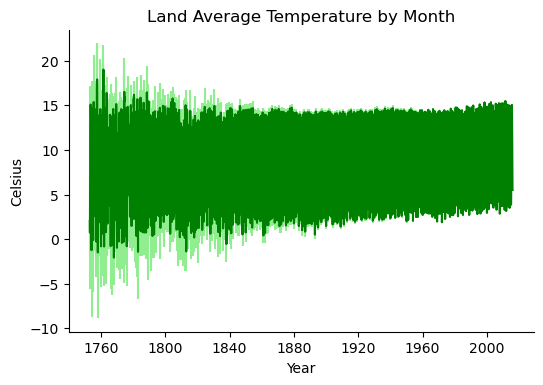

In [15]:
"""# plot LandAverageTemperature (green) and error bar 'LandAverageTemperatureUncertainty' (light green)"""

plt.figure(dpi=100)
plt.errorbar('dt', 'LandAverageTemperature', yerr='LandAverageTemperatureUncertainty', data=temperatures_1753_avg, color = 'green', ecolor='lightgreen')
ax1 = plt.gca()
ax1.set_title('Land Average Temperature by Month')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

#### Absolute Relative Uncertainty

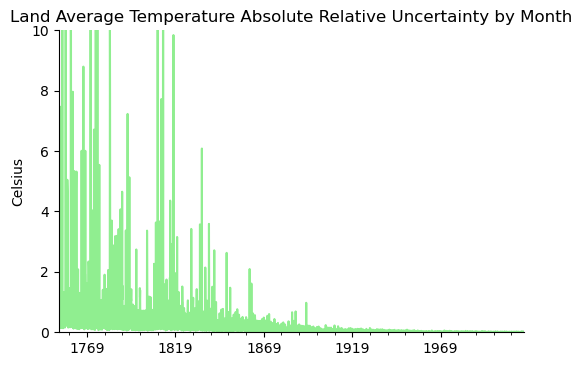

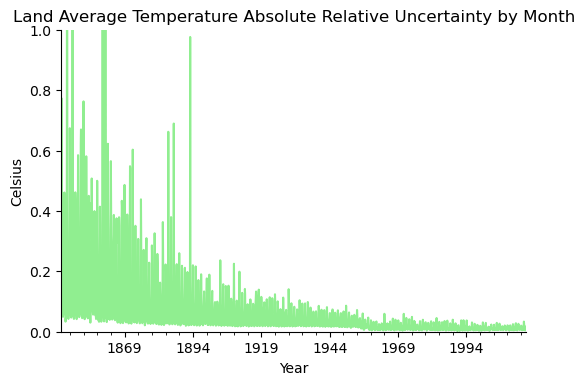

In [35]:
"""relative uncertainty"""
temperatures_1753_avg['LandAverageTemperatureRelativeUncertainty'] = (temperatures_1753_avg['LandAverageTemperatureUncertainty'] / temperatures_1753_avg['LandAverageTemperature']).abs()

"""# large relative error in earlier observations"""
plt.figure(dpi=100)
temperatures_1753_avg.plot(x = 'dt', y='LandAverageTemperatureRelativeUncertainty', color='lightgreen', ax = plt.gca())
ax1 = plt.gca()
ax1.set_title('Land Average Temperature Absolute Relative Uncertainty by Month')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
ax1.set_ylim(0,10)
ax1.set_xlabel(None)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.get_legend().remove()
# plt.savefig(r'plots/LandAverageTemperatureRelativeUncertainty_month1', dpi=150)

plt.figure(dpi=100)
temperatures_1753_avg.plot(x = 'dt', y='LandAverageTemperatureRelativeUncertainty', color='lightgreen', ax = plt.gca())
ax1 = plt.gca()
ax1.set_ylim(0,1)
ax1.set_title('Land Average Temperature Absolute Relative Uncertainty by Month')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
ax1.set_xlim(pd.Timestamp(1845, 12, 31))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.get_legend().remove()
# plt.savefig(r'plots/LandAverageTemperatureRelativeUncertainty_month2', dpi=150)

### LandAverageTemperature: Yearly mean temperature and uncertainty

In [4]:
def yearly_uncertainty(col):
    return np.sqrt(np.sum(col ** 2)) / len(col)

temperatures_1753_avg_yearly = temperatures_1753_avg[['dt', 'LandAverageTemperature']].groupby(pd.Grouper(key='dt', freq='1Y')).mean()
temperatures_1753_avg_yearly['LandAverageTemperatureUncertainty'] = temperatures_1753_avg.groupby(pd.Grouper(key='dt', freq='1Y'))['dt', 'LandAverageTemperatureUncertainty'].agg(yearly_uncertainty)
temperatures_1753_avg_yearly['LandAverageTemperatureRelativeUncertainty'] = (temperatures_1753_avg_yearly['LandAverageTemperatureUncertainty'] / temperatures_1753_avg_yearly['LandAverageTemperature']).abs()

temperatures_1753_avg_yearly.head()

C:\Users\CEDRIC~1\AppData\Local\Temp/ipykernel_16880/2418994677.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temperatures_1753_avg_yearly['LandAverageTemperatureUncertainty'] = temperatures_1753_avg.groupby(pd.Grouper(key='dt', freq='1Y'))['dt', 'LandAverageTemperatureUncertainty'].agg(yearly_uncertainty)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\groupby\generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


,LandAverageTemperature,LandAverageTemperatureUncertainty,LandAverageTemperatureRelativeUncertainty
dt,,,
1753-12-31,8.388083,0.970134,0.115656
1754-12-31,8.469333,1.091063,0.128825
1755-12-31,8.355583,1.153430,0.138043
1756-12-31,8.849583,0.981928,0.110958
1757-12-31,9.022000,1.180627,0.130861


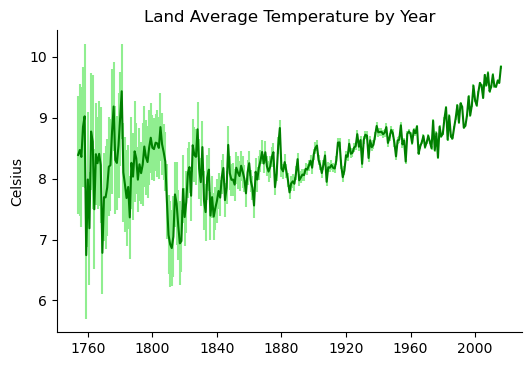

In [27]:
"""# plot yearly-averaged LandAverageTemperature and error bar 'LandAverageTemperatureUncertainty'"""
""" relative uncertainty becomes smaller after ca. 1850"""

plt.figure(dpi=100)
plt.errorbar(temperatures_1753_avg_yearly.index, 'LandAverageTemperature', yerr='LandAverageTemperatureUncertainty', data=temperatures_1753_avg_yearly, color = 'green', ecolor='lightgreen')
ax1 = plt.gca()
ax1.set_title('Land Average Temperature by Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
# ax1.set_ylim(0,10)
ax1.set_xlabel(None)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

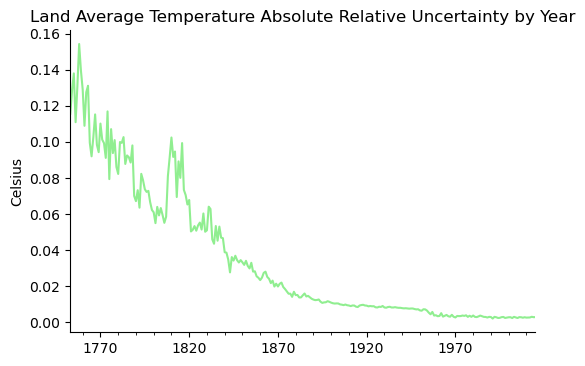

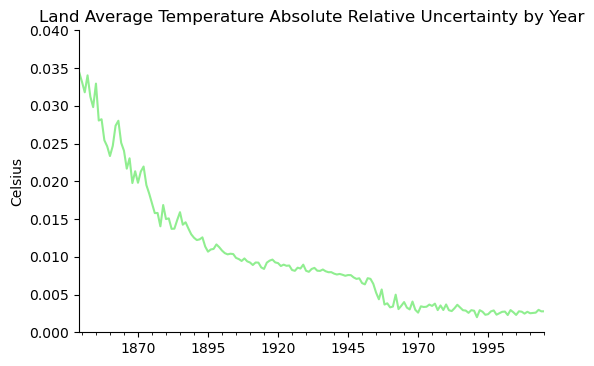

In [34]:
plt.figure(dpi=100)
temperatures_1753_avg_yearly.plot(y = 'LandAverageTemperatureRelativeUncertainty', color = 'lightgreen', ax = plt.gca())
ax1 = plt.gca()
ax1.set_title('Land Average Temperature Absolute Relative Uncertainty by Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
# ax1.set_ylim(0,10)
ax1.set_xlabel(None)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.get_legend().remove()

plt.figure(dpi=100)
temperatures_1753_avg_yearly.plot(y = 'LandAverageTemperatureRelativeUncertainty', color = 'lightgreen', ax = plt.gca())
ax1 = plt.gca()
ax1.set_title('Land Average Temperature Absolute Relative Uncertainty by Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
ax1.set_ylim(0,0.04)
ax1.set_xlim(pd.Timestamp(1849, 12, 31))
ax1.set_xlabel(None)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.get_legend().remove()

### Land Average/Max/Min Temperature: Yearly mean temperature and uncertainty

In [5]:
temperatures_1850_all.columns

Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty'],
      dtype='object')

In [6]:
# annual mean temperature and uncertainty
def yearly_uncertainty(col):
    return np.sqrt(np.sum(col ** 2)) / len(col)
temperatures_1850_all_yearly = temperatures_1850_all[['dt', 'LandAverageTemperature', 
                       'LandMaxTemperature', 'LandMinTemperature', 
                       'LandAndOceanAverageTemperature']].groupby(pd.Grouper(key='dt', freq='1Y')).mean()
temperatures_1850_all_yearly['LandAverageTemperatureUncertainty'] = temperatures_1850_all.groupby(pd.Grouper(key='dt', freq='1Y'))['dt', 'LandAverageTemperatureUncertainty'].agg(yearly_uncertainty)
temperatures_1850_all_yearly['LandMaxTemperatureUncertainty'] = temperatures_1850_all.groupby(pd.Grouper(key='dt', freq='1Y'))['dt', 'LandMaxTemperatureUncertainty'].agg(yearly_uncertainty)
temperatures_1850_all_yearly['LandMinTemperatureUncertainty'] = temperatures_1850_all.groupby(pd.Grouper(key='dt', freq='1Y'))['dt', 'LandMinTemperatureUncertainty'].agg(yearly_uncertainty)
temperatures_1850_all_yearly['LandAndOceanAverageTemperatureUncertainty'] = temperatures_1850_all.groupby(pd.Grouper(key='dt', freq='1Y'))['dt', 'LandAndOceanAverageTemperatureUncertainty'].agg(yearly_uncertainty)

C:\Users\CEDRIC~1\AppData\Local\Temp/ipykernel_16880/177883175.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temperatures_1850_all_yearly['LandAverageTemperatureUncertainty'] = temperatures_1850_all.groupby(pd.Grouper(key='dt', freq='1Y'))['dt', 'LandAverageTemperatureUncertainty'].agg(yearly_uncertainty)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\groupby\generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)
C:\Users\CEDRIC~1\AppData\Local\Temp/ipykernel_16880/177883175.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temperatures_1850_all_yearly['LandMaxTemperatureUncertainty'] = temperature

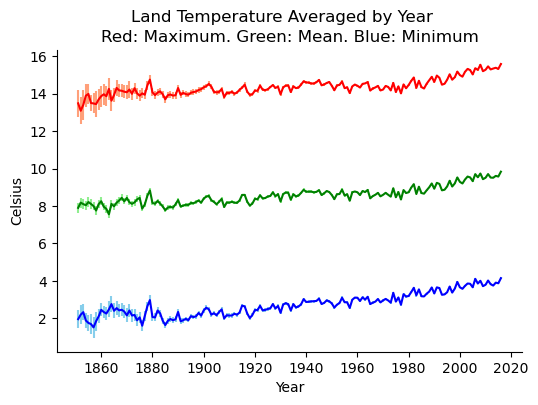

In [46]:
"""# plot yearly-averaged LandAverageTemperature and error bar 'LandAverageTemperatureUncertainty'"""

plt.figure(dpi=100)
plt.suptitle('Land Temperature Averaged by Year')
plt.errorbar(temperatures_1850_all_yearly.index, 'LandAverageTemperature', yerr='LandAverageTemperatureUncertainty', data=temperatures_1850_all_yearly, color = 'green', ecolor='lightgreen')
plt.errorbar(temperatures_1850_all_yearly.index, 'LandMaxTemperature', yerr='LandMaxTemperatureUncertainty', data=temperatures_1850_all_yearly, color = 'red', ecolor='lightsalmon')
plt.errorbar(temperatures_1850_all_yearly.index, 'LandMinTemperature', yerr='LandMinTemperatureUncertainty', data=temperatures_1850_all_yearly, color = 'blue', ecolor='skyblue')
ax1 = plt.gca()
ax1.set_title('Red: Maximum. Green: Mean. Blue: Minimum')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
# ax1.set_ylim(0,10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# plt.legend()

### Correlations between the temperatures

In [58]:
"""highly correlated at lag = 0"""

from scipy.stats import pearsonr

print(pearsonr(temperatures_yearly_first_diff['LandAverageTemperature'], temperatures_yearly_first_diff['LandMaxTemperature']))
# (0.7041473540151104, 5.074132061908521e-26)

print(pearsonr(temperatures_yearly_first_diff['LandAverageTemperature'], temperatures_yearly_first_diff['LandMinTemperature']))
# (0.8674877678792309, 2.675622965207922e-51)

print(pearsonr(temperatures_yearly_first_diff['LandMaxTemperature'], temperatures_yearly_first_diff['LandMinTemperature']))
# (0.7165142434197547, 2.7704818163204947e-27)

(0.7041473540151104, 5.074132061908521e-26)
(0.8674877678792309, 2.675622965207922e-51)
(0.7165142434197547, 2.7704818163204947e-27)


#### So it looks like the three time series behave very similarly. For our purpose, we just study the 'LandAverageTemperature'. Moreover, we use data starting from 1850 from now on, due to the smaller uncertainty.

## Augmented Dickey-Fuller test for non-stationarity

#### Non-stationarity is the null hypothesis; p-value > 0.05 infers non-stationary.

In [47]:
from statsmodels.tsa.stattools import adfuller

In [48]:
"""# p-values > 0.05: non-stationary"""
print(adfuller(temperatures_1850_all_yearly['LandAverageTemperature'])[1])
print(adfuller(temperatures_1850_all_yearly['LandMaxTemperature'])[1])
print(adfuller(temperatures_1850_all_yearly['LandMinTemperature'])[1])

0.9505464412068493
0.8231808221341292
0.9814993947787101


In [9]:
"""# first differences"""
temperatures_yearly_first_diff = temperatures_1850_all_yearly[['LandAverageTemperature', 'LandMaxTemperature', 'LandMinTemperature']].diff().iloc[1:]
# drop year 1850 (first row; NaN after first difference)

In [51]:
temperatures_yearly_first_diff.head()

,LandAverageTemperature,LandMaxTemperature,LandMinTemperature
dt,,,
1851-12-31,0.277917,-0.395667,0.239583
1852-12-31,-0.078417,0.316333,0.133083
1853-12-31,-0.058333,0.489250,-0.444500
1854-12-31,0.168667,0.090833,-0.130333
1855-12-31,-0.099750,-0.484250,-0.059333


In [50]:
"""# p-values for first differences << 0.05: stationary"""
print(adfuller(temperatures_yearly_first_diff['LandAverageTemperature'])[1])
print(adfuller(temperatures_yearly_first_diff['LandMaxTemperature'])[1])
print(adfuller(temperatures_yearly_first_diff['LandMinTemperature'])[1])

2.625626865464363e-25
6.030368572920849e-24
1.3653286686687314e-08


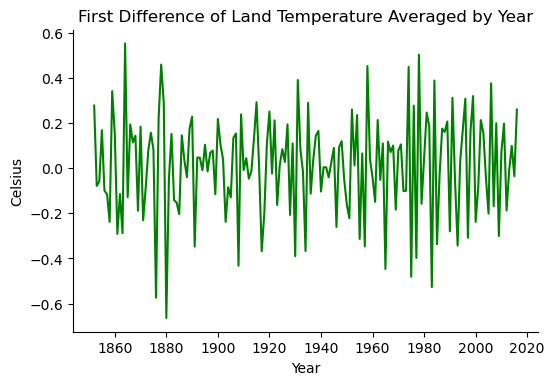

In [10]:
"""# plot first difference of yearly-averaged LandAverageTemperature and error bar 'LandAverageTemperatureUncertainty'"""

plt.figure(dpi=100)
plt.errorbar(temperatures_yearly_first_diff.index, 'LandAverageTemperature', data=temperatures_yearly_first_diff, color = 'green', ecolor='lightgreen')
# plt.errorbar(temperatures_yearly_first_diff.index, 'LandMaxTemperature', data=temperatures_yearly_first_diff, color = 'red', ecolor='lightsalmon')
# plt.errorbar(temperatures_yearly_first_diff.index, 'LandMinTemperature', data=temperatures_yearly_first_diff, color = 'blue', ecolor='skyblue')
ax1 = plt.gca()
# ax1.set_ylim(0,10)
plt.title('First Difference of Land Temperature Averaged by Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# ax1.get_legend().remove()

## Auto-correlation function (ACF) and partial auto-correlation function (PACF)

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

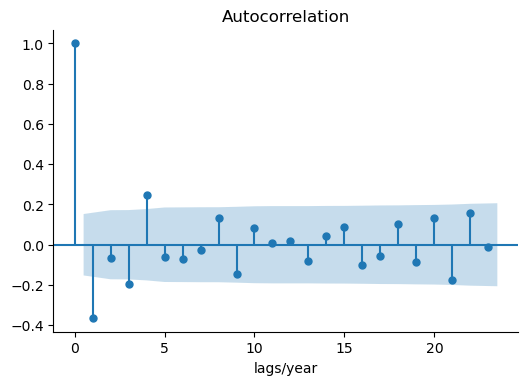

In [56]:
"""# Auto-correlations"""
plt.figure(dpi=100)
plot_acf(temperatures_yearly_first_diff['LandAverageTemperature'], ax = plt.gca());
ax1 = plt.gca()
ax1.set_xlabel('lags/year')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# plt.savefig(r'plots/LandAverageTemperature_year_first_diff_ACF', dpi=150)

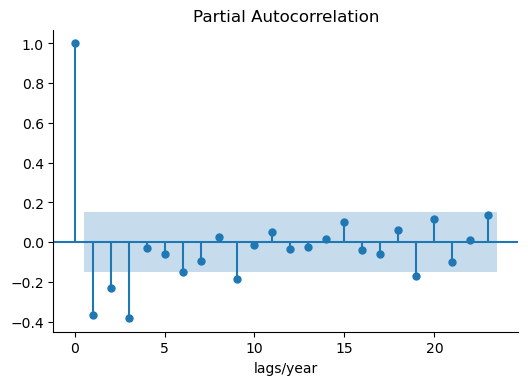

In [57]:
"""# Partial auto-correlations"""
plt.figure(dpi=100)
plot_pacf(temperatures_yearly_first_diff['LandAverageTemperature'], ax = plt.gca());
ax1 = plt.gca()
ax1.set_xlabel('lags/year')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# plt.savefig(r'plots/LandAverageTemperature_year_first_diff_PACF', dpi=150)

#### The decay in ACF, and the PACF, suggest AR(3).

## Train-validation (initial) split 

In [20]:
# temperatures_yearly_first_diff.index[0]
# Timestamp('1851-12-31 00:00:00', freq='A-DEC')
# temperatures_yearly_first_diff.index[-1]
# Timestamp('2015-12-31 00:00:00', freq='A-DEC')

"""split at 1986; 1851-1985 is training set, 1986-2015 is validation set"""
split_time = pd.Timestamp(1986,6,30)
# temperatures_yearly_first_diff.index[136]
# Timestamp('1986-12-31 00:00:00', freq='A-DEC')
# 136


temperatures_1850_all_yearly_train = temperatures_1850_all_yearly[temperatures_1850_all_yearly.index < split_time]
temperatures_yearly_first_diff_train = temperatures_yearly_first_diff[temperatures_yearly_first_diff.index < split_time]

temperatures_1850_all_yearly_valid = temperatures_1850_all_yearly[temperatures_1850_all_yearly.index > split_time]
temperatures_yearly_first_diff_valid = temperatures_yearly_first_diff[temperatures_yearly_first_diff.index > split_time]

## Naive forecase (lag 1)

In [22]:
temperature_yearly_naive = [np.nan] + temperatures_1850_all_yearly['LandAverageTemperature'].to_list()[:-1]

In [16]:
from sklearn.metrics import mean_absolute_error

In [23]:
mean_absolute_error(temperatures_1850_all_yearly_valid['LandAverageTemperature'], pd.Series(temperature_yearly_naive[-30:], index = temperatures_1850_all_yearly_valid.index))

0.18930555555555575

## Auto-regressive (AR) models

In [60]:
from sklearn.metrics import mean_absolute_error
# ARIMA models
from statsmodels.tsa.arima_model import ARIMA

In [61]:
"""fit model of the initial fixed partition"""
model1 = ARIMA(temperatures_yearly_first_diff_train['LandAverageTemperature'], order=(3,0,0))
model1_fit = model1.fit()

# summary of the model
print(model1_fit.summary())

                                ARMA Model Results                                
Dep. Variable:     LandAverageTemperature   No. Observations:                  135
Model:                         ARMA(3, 0)   Log Likelihood                  34.518
Method:                           css-mle   S.D. of innovations              0.187
Date:                    Sun, 07 Nov 2021   AIC                            -59.035
Time:                            00:01:57   BIC                            -44.509
Sample:                        12-31-1851   HQIC                           -53.132
                             - 12-31-1985                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.0053      0.007      0.749      0.454      -0.009       0.019
ar.L1.LandAverageTemperature    -0.5168      

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


#### Indeed, p-values are small (zero) at lag = 1, 2, 3.

### [Fixed window] predictions/forecast

In [63]:
"""# in-sample (training set) prediction of first difference """
pred_diff_train1 = model1_fit.predict(start=temperatures_yearly_first_diff_train.index[0], end=temperatures_yearly_first_diff_train.index[-1])

# add back the trend
predictions_train1 = temperatures_1850_all_yearly_train['LandAverageTemperature'].shift() + pred_diff_train1

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [64]:
"""# mean_absolute_error of the training set """
mean_absolute_error(temperatures_1850_all_yearly_train['LandAverageTemperature'].iloc[1:],predictions_train1.iloc[1:])

0.14860975236678103

#### [fixed window], out-of-sample forecast of first difference

In [65]:
""" [fixed window], out-of-sample forecast of first difference """

forecast_diff1 = model1_fit.forecast(len(temperatures_yearly_first_diff_valid))[0]

fixed_wind_forecast1 = []
for i in range(len(temperatures_yearly_first_diff_valid)):
    if i == 0:
        fixed_wind_forecast1.append(temperatures_1850_all_yearly_train['LandAverageTemperature'][-1] + forecast_diff1[i])
    else:
        fixed_wind_forecast1.append(temperatures_1850_all_yearly_valid['LandAverageTemperature'][i-1] + forecast_diff1[i])

fixed_wind_forecast1 = pd.Series(fixed_wind_forecast1, index = temperatures_1850_all_yearly_valid.index)

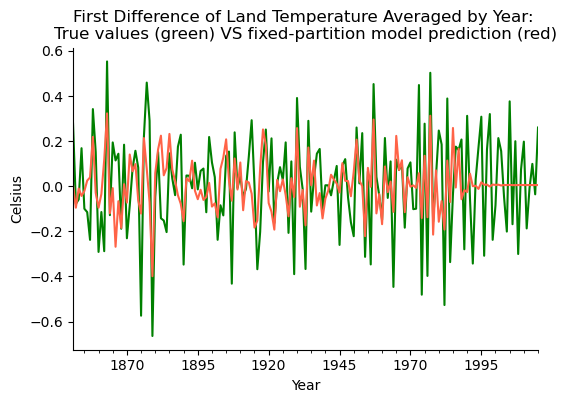

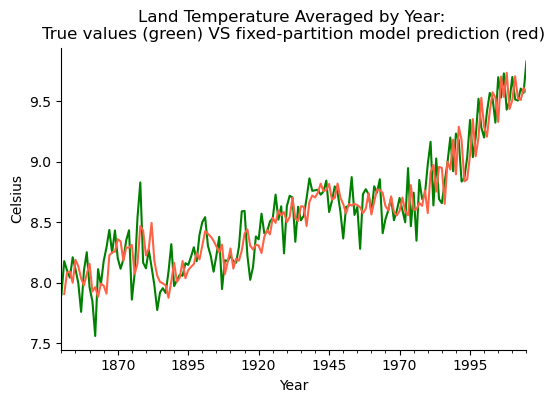

In [76]:
plt.figure(dpi=100)
temperatures_yearly_first_diff['LandAverageTemperature'].plot(ax=plt.gca())
pd.concat([pred_diff_train1, pd.Series(forecast_diff1, index = temperatures_yearly_first_diff_valid.index)], axis = 0).plot(ax=plt.gca())
ax1 = plt.gca()
ax1.get_lines()[0].set_color("green")
ax1.get_lines()[1].set_color("tomato")
plt.title('First Difference of Land Temperature Averaged by Year: \nTrue values (green) VS fixed-partition model prediction (red)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# plt.savefig(r'plots/LandAverageTemperature_year_AR3_fixed_partition_first_diff', dpi=150)


plt.figure(dpi=100)
temperatures_1850_all_yearly['LandAverageTemperature'].plot(ax=plt.gca())
pd.concat([predictions_train1, fixed_wind_forecast1], axis = 0).plot(ax=plt.gca())
ax1 = plt.gca()
ax1.get_lines()[0].set_color("green")
ax1.get_lines()[1].set_color("tomato")
plt.title('Land Temperature Averaged by Year: \nTrue values (green) VS fixed-partition model prediction (red)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# ax1.get_legend().get_texts()[0].set_text('AR(3) fixed partition forecast')
# ax1.get_legend().get_texts()[1].set_text('True values')
# plt.savefig(r'plots/LandAverageTemperature_year_AR3_fixed_partition', dpi=150)

#### Validation MAE

In [67]:
print(mean_absolute_error(temperatures_yearly_first_diff_valid['LandAverageTemperature'], pd.Series(forecast_diff1, index = temperatures_yearly_first_diff_valid.index)))
print(mean_absolute_error(temperatures_1850_all_yearly_valid['LandAverageTemperature'], fixed_wind_forecast1))

0.18836564357881894
0.1883656435788189


#### The forecast first difference of the fixed-partitioning model is basically zero; this reduces to a naive forecast by the value of the previous time-step.

### Rolling forecast

#### Walk-forward validation

In [ ]:
size = 136
# temperatures_1850_all_yearly.index[136]
# Out[159]: Timestamp('1986-12-31 00:00:00', freq='A-DEC')
history1 = temperatures_yearly_first_diff_train['LandAverageTemperature'].to_list()
rolling_forecast_first_diff1 = []


for t in range(len(temperatures_1850_all_yearly_valid)):
	model = ARIMA(history1, order=(3,0,0))
	model_fit = model.fit()
	output = model_fit.forecast() # outputs an array of 1 element
	yhat = output[0][0] # the forecast one time step ahead
	rolling_forecast_first_diff1.append(yhat)
	obs = temperatures_yearly_first_diff_valid['LandAverageTemperature'].iloc[t]
	history1.append(obs) # append value of current time step for next model

#### [rolling window], out-of-sample forecast from first difference

In [78]:
""" [rolling window], out-of-sample forecast of first difference """

rolling_forecast1 = []
for i in range(len(temperatures_yearly_first_diff_valid)):
    if i == 0:
        rolling_forecast1.append(temperatures_1850_all_yearly_train['LandAverageTemperature'][-1] + rolling_forecast_first_diff1[0])
    else:
        rolling_forecast1.append(temperatures_1850_all_yearly_valid['LandAverageTemperature'][i-1] + rolling_forecast_first_diff1[i])

rolling_forecast1 = pd.Series(rolling_forecast1, index = temperatures_1850_all_yearly_valid.index)

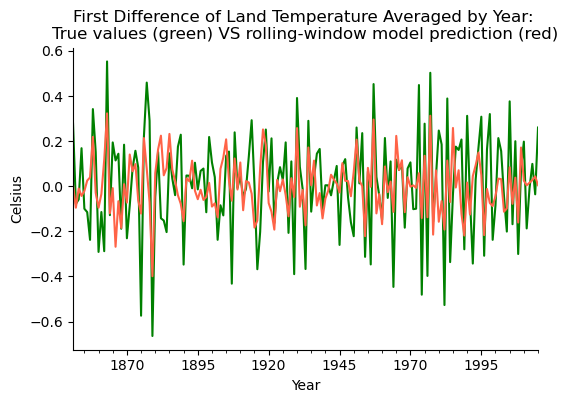

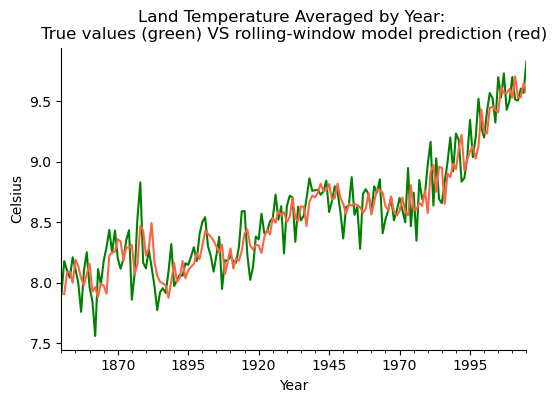

In [80]:
plt.figure(dpi=100)
temperatures_yearly_first_diff['LandAverageTemperature'].plot(ax=plt.gca())
pd.concat([pred_diff_train1, pd.Series(rolling_forecast_first_diff1, index = temperatures_yearly_first_diff_valid.index)], axis = 0).plot(ax=plt.gca())
ax1 = plt.gca()
ax1.get_lines()[0].set_color("green")
ax1.get_lines()[1].set_color("tomato")
plt.title('First Difference of Land Temperature Averaged by Year: \nTrue values (green) VS rolling-window model prediction (red)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# plt.savefig(r'plots/LandAverageTemperature_year_AR3_rolling_forecast_first_diff', dpi=150)


plt.figure(dpi=100)
temperatures_1850_all_yearly['LandAverageTemperature'].plot(ax=plt.gca())
pd.concat([predictions_train1, rolling_forecast1], axis = 0).plot(ax=plt.gca())
ax1 = plt.gca()
ax1.get_lines()[0].set_color("green")
ax1.get_lines()[1].set_color("tomato")
plt.title('Land Temperature Averaged by Year: \nTrue values (green) VS rolling-window model prediction (red)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

#### Validation MAE

In [79]:
print(mean_absolute_error(temperatures_yearly_first_diff_valid['LandAverageTemperature'], pd.Series(rolling_forecast_first_diff1, index = temperatures_yearly_first_diff_valid.index))
)


0.15548113397624228


#### Smaller error indeed, compared to fixed-partition forecast.

## Summary of Results

Validation (data from 1986 onward) MAE:<br>
Naive forecast (lag 1): 0.18930555555555575<br>
AR(3) fixed partitioning: 0.1883656435788189<br>
AR(3) rolling forecast: 0.15548113397624228